In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split


In [3]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')


RuntimeError: Visible devices cannot be modified after being initialized

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# ---------------------------
# Aggregation Layer
# ---------------------------
class AggregationLayer(layers.Layer):
    """
    Aggregates a set of features over the sequence dimension.
    Supported aggregations: "mean" or "max".
    """
    def __init__(self, aggreg="mean", **kwargs):
        super(AggregationLayer, self).__init__(**kwargs)
        self.aggreg = aggreg

    def call(self, inputs):
        if self.aggreg == "mean":
            return tf.reduce_mean(inputs, axis=1)
        elif self.aggreg == "max":
            return tf.reduce_max(inputs, axis=1)
        else:
            raise ValueError("Given aggregation string is not implemented. Use 'mean' or 'max'.")

# ---------------------------
# Linformer Multi-Head Attention
# ---------------------------
class LinformerMultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads, proj_dim, **kwargs):
        """
        Args:
          d_model: Dimensionality of the model.
          num_heads: Number of attention heads.
          proj_dim: The projection dimension to which keys and values will be reduced.
        """
        super(LinformerMultiHeadAttention, self).__init__(**kwargs)
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.proj_dim = proj_dim

    def build(self, input_shape):
        # input_shape: (batch_size, seq_len, d_model)
        self.seq_len = input_shape[1]
        # Standard dense weight matrices for Q, K, and V.

        self.wv = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wv")
        self.dense = layers.Dense(self.d_model)

        self.F = self.add_weight(shape=(self.num_heads, self.seq_len, self.proj_dim),
                                 initializer='glorot_uniform',
                                 trainable=True,
                                 name="proj_F")
        super(LinformerMultiHeadAttention, self).build(input_shape)

    def split_heads(self, x, batch_size):
        # x shape: (batch_size, seq_len, d_model)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        # Transpose to shape: (batch_size, num_heads, seq_len, depth)
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, x):
        batch_size = tf.shape(x)[0]
        v = tf.matmul(x, self.wv)


        v = self.split_heads(v, batch_size)


        v_proj = tf.einsum('bhnd, hnr -> bhrd', v, self.F)
    
        attn_output = v_proj
        attn_output = tf.transpose(attn_output, perm=[0, 2, 1, 3])
        print(attn_output.shape)

        concat_output = tf.reshape(attn_output, (batch_size, -1, self.d_model))
        print(concat_output.shape)
        output = self.dense(concat_output)
        print(output.shape)
        return output

# ---------------------------
# Linformer Transformer Block
# ---------------------------
class LinformerTransformerBlock(layers.Layer):
    def __init__(self, d_model, d_ff, output_dim, num_heads, proj_dim, **kwargs):
        super(LinformerTransformerBlock, self).__init__(**kwargs)
        self.attention = LinformerMultiHeadAttention(d_model, num_heads, proj_dim)
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            layers.Dense(d_ff, activation='relu'),
            layers.Dense(d_model)
        ])

    def call(self, x):
        attn_output = self.attention(x)
        print(x.shape)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

# ---------------------------
# Linformer Transformer Classifier Model
# ---------------------------
def build_linformer_transformer_classifier(num_particles, feature_dim,
                                             d_model=16, d_ff=16, output_dim=16,
                                             num_heads=8, proj_dim=8):
    """
    Builds a classifier model with:
      - A linear embedding layer.
      - Multiple Linformer transformer blocks.
      - Aggregation over the sequence dimension.
      - A final linear output layer for 5 classes.
    """
    inputs = layers.Input(shape=(num_particles, feature_dim))
    
    x = layers.Dense(d_model, activation='relu')(inputs)
    
    x = LinformerTransformerBlock(d_model, d_ff, output_dim, num_heads, proj_dim)(x)    
    
    pooled_output = AggregationLayer(aggreg='max')(x)
    
    x = layers.Dense(d_model, activation='relu')(pooled_output)
    outputs = layers.Dense(5, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=outputs)

# ---------------------------
# Example Training Setup
# ---------------------------
import numpy as np
from sklearn.model_selection import train_test_split

# Load your data.
x_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_train_robust_32const_ptetaphi.npy")
y_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_train_robust_32const_ptetaphi.npy")

# 80/20 split for training and validation.
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, shuffle=True
)

# Determine input dimensions from data.
num_particles = x_train.shape[1]
feature_dim = x_train.shape[-1]

# Build and compile the Linformer transformer classifier.
model = build_linformer_transformer_classifier(num_particles, feature_dim,
                                               d_model=16, d_ff=16, output_dim=16,
                                               num_heads=8, proj_dim=1)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()




(None, 1, 8, 2)
(None, None, 16)
(None, None, 16)
(None, 32, 16)
(None, 1, 8, 2)
(None, None, 16)
(None, None, 16)
(None, 32, 16)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linformer_transformer_block_2   │ (None, 32, 16)         │         1,392 │
│ (LinformerTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_2             │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,813 (7.08 KB)

 Trainable params: 1,813 (7.08 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=500, 
    batch_size=1024)

Epoch 1/500
(None, 1, 8, 2)
(None, None, 16)
(None, None, 16)
(None, 32, 16)


2025-04-03 12:55:05.110595: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


(None, 1, 8, 2)
(None, None, 16)
(None, None, 16)
(None, 32, 16)
 18/485 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.2173 - loss: 2.6287

KeyboardInterrupt: 

In [31]:
model.save_weights('1layerLinformerCompressOne32partCompress1.weights.h5')

In [41]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph
import time
import numpy as np

def get_flops(model, input_shape):
    # Create a concrete function from the Keras model.
    input_tensor = tf.TensorSpec(input_shape, tf.float32)
    concrete_func = tf.function(model).get_concrete_function(input_tensor)
    
    # Convert the model to a frozen graph.
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)
    
    # Import the graph_def into a new graph.
    with tf.Graph().as_default() as graph:
        tf.compat.v1.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)
        return flops.total_float_ops

# Assuming x_val is already loaded and has shape (num_samples, features, ...)
# For a single event, we use a batch size of 1.
input_shape = [1] + list(x_val.shape[1:])
total_flops = get_flops(model, input_shape)
print("Total FLOPs for a single inference:", total_flops)

# ---------------------------
# Time Inference Per Event
# ---------------------------
# Warm-up: Run one inference to load any lazy initializations.
import numpy as np
import time

# Warm-up (optional but recommended)
_ = model(x_val[:10000])

num_trials = 100
inference_times = []
for _ in range(num_trials):
    start_time = time.perf_counter()
    _ = model(x_val[:10000])
    end_time = time.perf_counter()
    inference_times.append(end_time - start_time)

# Compute average inference time per event in seconds, then convert to nanoseconds
avg_inference_time_seconds = np.mean(np.array(inference_times) / 10000)
avg_inference_time_nanoseconds = avg_inference_time_seconds * 1e9

print("Average inference time per event:", np.round(avg_inference_time_nanoseconds,3), "nanoseconds")



2025-03-27 04:48:43.527074: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2025-03-27 04:48:43.527148: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-03-27 04:48:43.527295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-27 04:48:43.527304: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Total FLOPs for a single inference:
=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Pl

In [42]:
x_val = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_val_robust_32const_ptetaphi.npy")
y_val = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_val_robust_32const_ptetaphi.npy")

In [43]:
xout = np.argmax(model(x_val, training=False),1)
yout = np.argmax(y_val,1)

In [9]:
import sklearn
sklearn.metrics.accuracy_score(xout,yout)

NameError: name 'xout' is not defined

In [46]:
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 32, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 32, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linformer_transformer_block_8   │ (None, 32, 16)         │         2,160 │
│ (LinformerTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_8             │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,745 (30.26 KB)

 Trainable params: 2,581 (10.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,164 (20.18 KB)

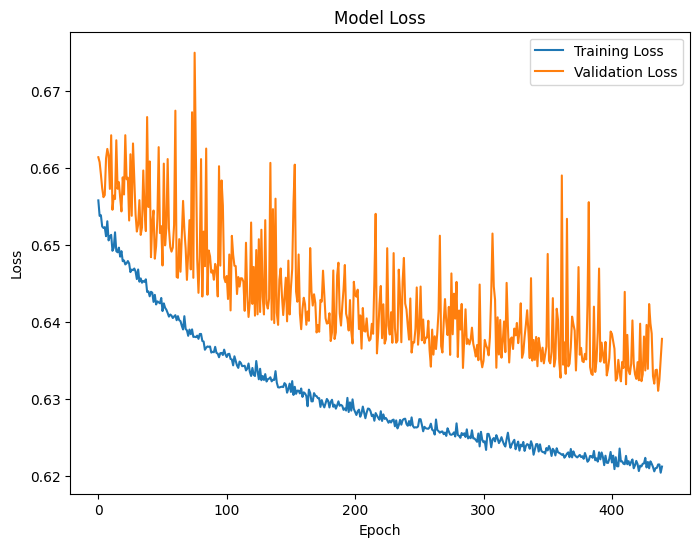

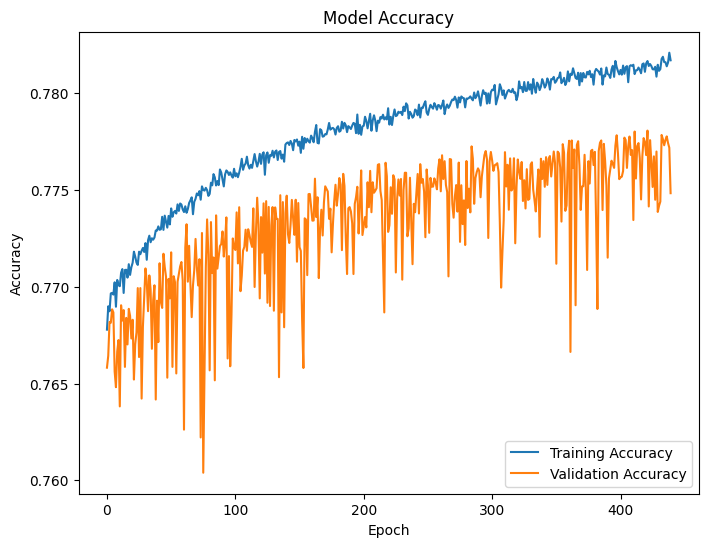

In [47]:
import matplotlib.pyplot as plt

# Suppose you have already trained your model:
# history = model.fit(...)

# Plotting the training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# If you also have accuracy or other metrics, you can plot them similarly:
if 'accuracy' in history.history:
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()


1/FPR at TPR=80% for each class:
g: 1/FPR = 8.931933568539712
q: 1/FPR = 7.990694836396919
W: 1/FPR = 26.286057692307693
Z: 1/FPR = 29.876582278481013
t: 1/FPR = 23.768622507449003
Average 1/FPR across classes: 19.370778176634865

Accuracy at the threshold corresponding to TPR=80% for each class:
g: accuracy = 0.8703
q: accuracy = 0.8603
W: accuracy = 0.9294
Z: accuracy = 0.9330
t: accuracy = 0.9260
Average accuracy across classes: 0.9038


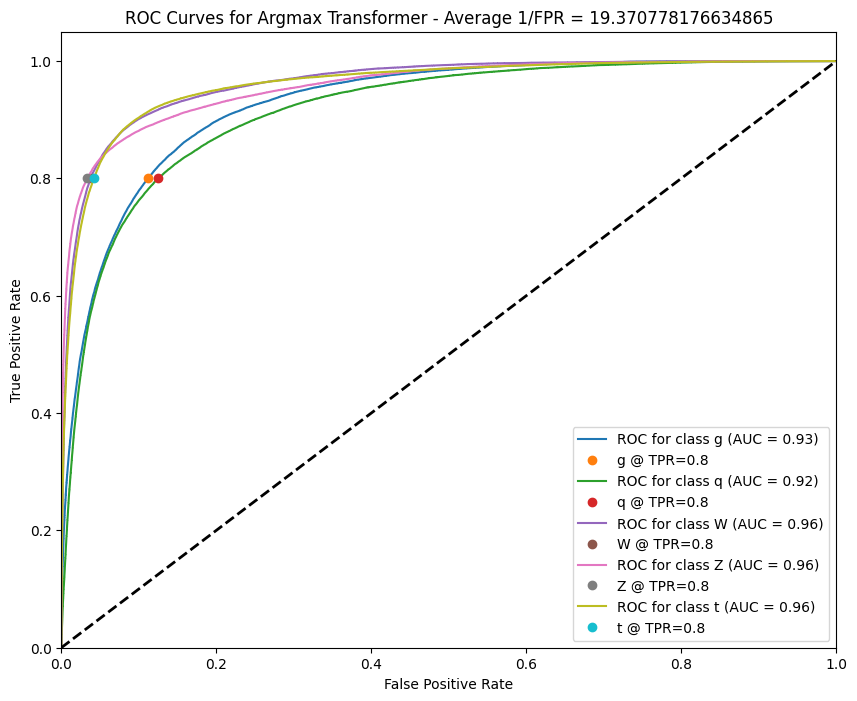

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf

# Define your class labels.
class_labels = ['g', 'q', 'W', 'Z', 't']

# Load your validation data.
# (Assuming x_val and y_val are already loaded in your environment)
# Get the model predictions as probabilities.
# If your model outputs logits, you may need to apply softmax first.
y_pred = model(x_val, training=False)

# Convert predictions and labels from TensorFlow tensors to NumPy arrays if needed.
if hasattr(y_pred, "numpy"):
    y_pred = y_pred.numpy()
if hasattr(y_val, "numpy"):
    y_val = y_val.numpy()

# Initialize dictionaries to store false positive rates, true positive rates, AUC, thresholds,
# interpolated FPR at target TPR, and accuracy at that threshold.
fpr = {}
tpr = {}
roc_auc = {}
thresholds_dict = {}
fpr_at_target = {}
accuracy_at_target = {}

# Target true positive rate.
target_tpr = 0.8

# Compute ROC curve, AUC, and interpolate FPR and threshold at target TPR for each class.
for i, label in enumerate(class_labels):
    # Compute ROC curve: returns fpr, tpr, and thresholds.
    fpr[i], tpr[i], thresholds = roc_curve(y_val[:, i], y_pred[:, i])
    thresholds_dict[i] = thresholds  # save thresholds for later use
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Check if the target TPR is reached.
    if target_tpr <= tpr[i][-1]:
        # Interpolate FPR at target TPR.
        fpr_at_target[label] = np.interp(target_tpr, tpr[i], fpr[i])
        # Interpolate threshold at target TPR.
        threshold_at_target = np.interp(target_tpr, tpr[i], thresholds)
        # Compute binary predictions for the current class using the interpolated threshold.
        preds_binary = (y_pred[:, i] >= threshold_at_target).astype(int)
        # Compute accuracy for the current class.
        accuracy = np.mean(preds_binary == y_val[:, i])
        accuracy_at_target[label] = accuracy
    else:
        fpr_at_target[label] = None  # If target TPR is not reached.
        accuracy_at_target[label] = None

# Display the 1/FPR values when TPR=80% for each class.
print("1/FPR at TPR=80% for each class:")
one_over_fpr = []
for label in class_labels:
    if fpr_at_target[label] is not None and fpr_at_target[label] != 0:
        inv_val = 1.0 / fpr_at_target[label]
        one_over_fpr.append(inv_val)
        print(f"{label}: 1/FPR = {inv_val}")
    else:
        print(f"{label}: undefined (FPR is None or zero)")

# Compute and print the average of 1/FPR across classes.
if one_over_fpr:
    avg_one_over_fpr = np.mean(one_over_fpr)
    print(f"Average 1/FPR across classes: {avg_one_over_fpr}")
else:
    print("No valid 1/FPR values to compute an average.")

# Print the accuracy at the FPR corresponding to TPR=80% for each class.
print("\nAccuracy at the threshold corresponding to TPR=80% for each class:")
accuracies = []
for label in class_labels:
    if accuracy_at_target[label] is not None:
        accuracies.append(accuracy_at_target[label])
        print(f"{label}: accuracy = {accuracy_at_target[label]:.4f}")
    else:
        print(f"{label}: accuracy undefined (target TPR not reached)")
if accuracies:
    avg_accuracy = np.mean(accuracies)
    print(f"Average accuracy across classes: {avg_accuracy:.4f}")
else:
    print("No valid accuracy values to compute an average.")

# Plot the ROC curves and mark the point corresponding to TPR=0.8.
plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    plt.plot(fpr[i], tpr[i], label=f'ROC for class {label} (AUC = {roc_auc[i]:.2f})')
    if fpr_at_target[label] is not None:
        # Mark the point on the ROC curve where TPR = 0.8.
        plt.plot(fpr_at_target[label], target_tpr, 'o', label=f'{label} @ TPR=0.8')

# Plot the random chance line.
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Argmax Transformer - Average 1/FPR = ' + str(avg_one_over_fpr))
plt.legend(loc="lower right")
plt.show()

